In [1]:
! pip install git+https://github.com/firekind/athena

  Cloning https://github.com/firekind/athena to /tmp/pip-req-build-p_j1b3z0
  Running command git clone -q https://github.com/firekind/athena /tmp/pip-req-build-p_j1b3z0
  Created wheel for athena: filename=athena-1.0.0-cp36-none-any.whl size=49671 sha256=9aac4db579e6e0e8ab8250ef6a34266d5cb3d4ee0589a64e554b5095e29dad27
  Stored in directory: /tmp/pip-ephem-wheel-cache-32ago8_d/wheels/36/d3/7b/d9500a9af2498abc5d48d60c7db37c1456ee745049da352e0b
Successfully built athena


In [2]:
import cv2
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import albumentations as A
from athena import datasets, Experiments, ClassificationSolver
from athena.models import ResNet18
from athena.utils.transforms import ToNumpy, ToTensor
from athena.tuning.lr_finder import LRFinder
from athena.visualizations import plot_experiments, gradcam_misclassified

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128 if torch.cuda.is_available() else 64
epochs = 40

In [4]:
train_loader = (
    datasets.cifar10()
    .batch_size(batch_size)
    .train()
    .transform(A.Compose([
        A.Lambda(ToNumpy),
        A.PadIfNeeded(36, 36, border_mode=cv2.BORDER_CONSTANT, value=0),
        A.RandomCrop(32, 32),
        A.HorizontalFlip(),
        A.Normalize(mean=datasets.cifar10.mean, std=datasets.cifar10.std, max_pixel_value=1.0),
        A.Lambda(ToTensor)
    ]))
    .build()
)

test_loader = (
    datasets.cifar10()
    .batch_size(batch_size)
    .test()
    .transform(A.Compose([
        A.Lambda(ToNumpy),
        A.Normalize(mean=datasets.cifar10.mean, std=datasets.cifar10.std, max_pixel_value=1.0),
        A.Lambda(ToTensor)
    ]))
    .build()
)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
model = ResNet18()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lr_finder = LRFinder(model, optimizer, F.cross_entropy, device=device)





Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.23E-02


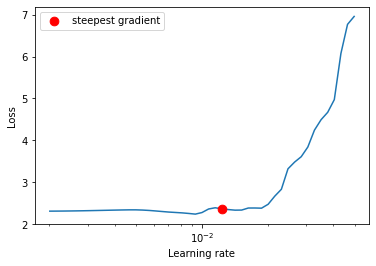

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.00E-02


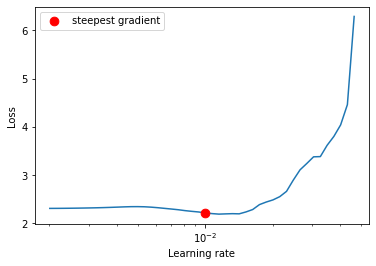

In [6]:
# Finding best LR for model
# range test
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=100, step_mode="exp")
res = lr_finder.plot()
lr_finder.reset()
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=1, num_iter=100, step_mode="exp")
res = lr_finder.plot()

In [9]:
exps = (
    Experiments.builder()
    .name("ResNet_LR_Finder")
    .log_directory("./logs")
    .add("lr: 1.23e-02, Patience: 5, factor: 0.5")
        .model(ResNet18())
        .solver(ClassificationSolver)
            .epochs(epochs)
            .optimizer(optim.SGD, lr=1.23e-2, momentum=0.9)
            .scheduler(ReduceLROnPlateau, patience=5, factor=0.5)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device(device)
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .add("lr: 1e-02, Patience: 5, factor: 0.5")
        .model(ResNet18())
        .solver(ClassificationSolver)
            .epochs(epochs)
            .optimizer(optim.SGD, lr=1e-02, momentum=0.9)
            .scheduler(ReduceLROnPlateau, patience=5, factor=0.5)
            .train_loader(train_loader)
            .test_loader(test_loader)
            .loss_fn(F.cross_entropy)
            .device(device)
            .max_checkpoints_to_keep(3)
            .build()
        .build()
    .build()
)

In [10]:
exps.run()

=> Running experiment: lr: 1.23e-02, Patience: 5, factor: 0.5
Epoch: 1 / 40
391/391 [==============================] - 61s 156ms/step - train loss: 1.3725 - train accuracy: 50.0560
Test set: Average loss: 1.3588, Accuracy: 5473/10000 (54.73%)

Epoch: 2 / 40
391/391 [==============================] - 60s 154ms/step - train loss: 0.8462 - train accuracy: 70.2480
Test set: Average loss: 0.7620, Accuracy: 7433/10000 (74.33%)

Epoch: 3 / 40
391/391 [==============================] - 61s 155ms/step - train loss: 0.6402 - train accuracy: 77.5360
Test set: Average loss: 0.6919, Accuracy: 7613/10000 (76.13%)

Epoch: 4 / 40
391/391 [==============================] - 60s 155ms/step - train loss: 0.5303 - train accuracy: 81.5120
Test set: Average loss: 0.6078, Accuracy: 7981/10000 (79.81%)

Epoch: 5 / 40
391/391 [==============================] - 60s 155ms/step - train loss: 0.4605 - train accuracy: 84.0880
Test set: Average loss: 0.5907, Accuracy: 8104/10000 (81.04%)

Epoch: 6 / 40
391/391 [=====

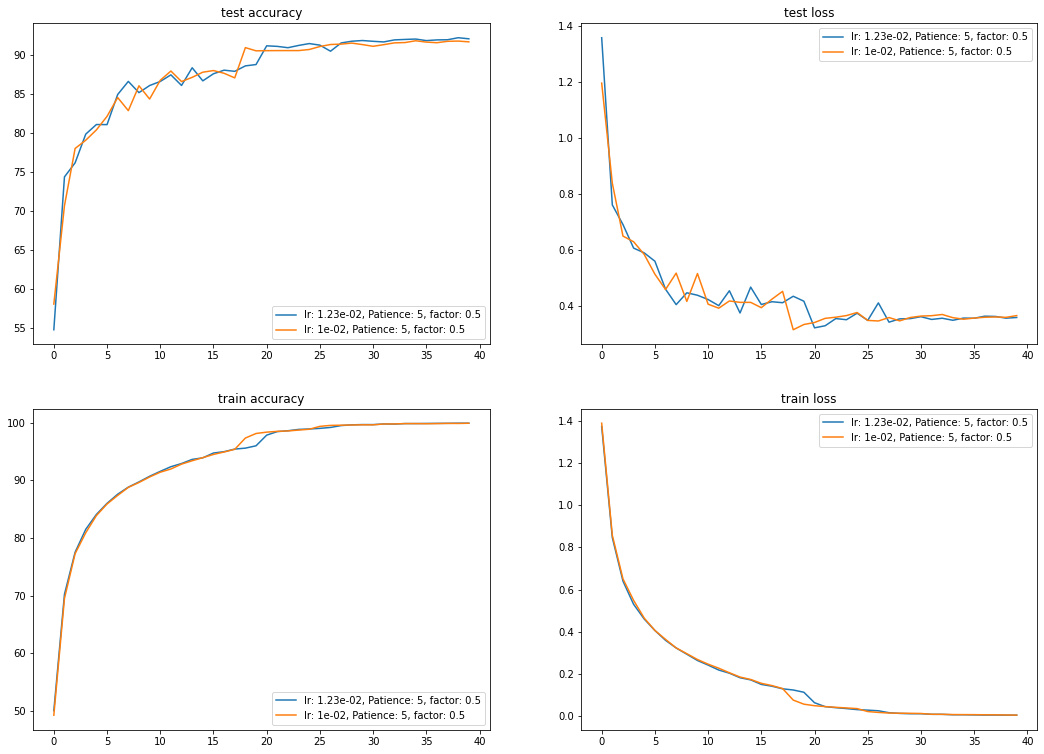

In [11]:
plot_experiments(exps)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


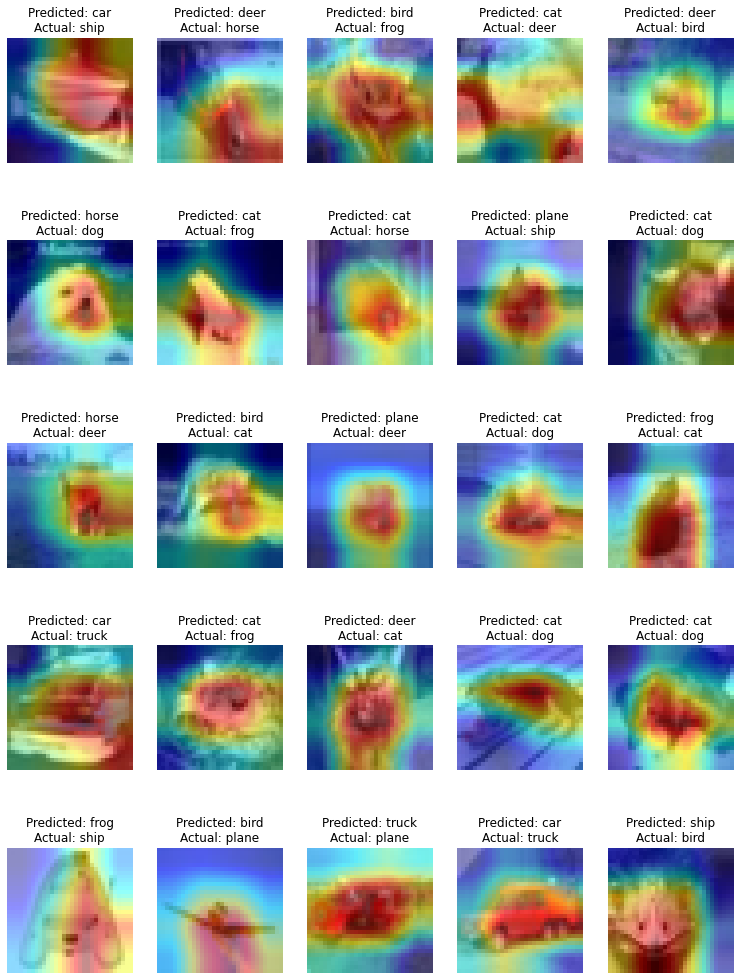

In [14]:
gradcam_misclassified(
    25,
    exps["lr: 1.23e-02, Patience: 5, factor: 0.5"],
    exps["lr: 1.23e-02, Patience: 5, factor: 0.5"].get_solver().model.layer4[1],
    test_loader,
    device,
    class_labels=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
    mean=datasets.cifar10.mean,
    std=datasets.cifar10.std,
    alpha=0.8,
    figsize=(13, 18)
)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


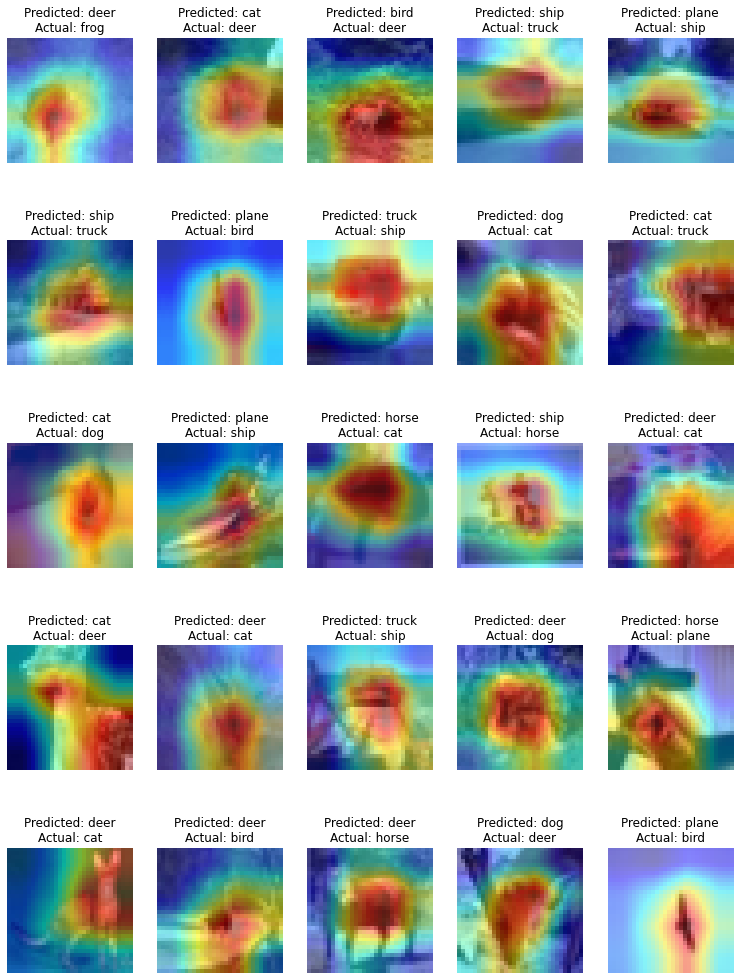

In [15]:
gradcam_misclassified(
    25,
    exps["lr: 1e-02, Patience: 5, factor: 0.5"],
    exps["lr: 1e-02, Patience: 5, factor: 0.5"].get_solver().model.layer4[1],
    test_loader,
    device,
    class_labels=('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
    mean=datasets.cifar10.mean,
    std=datasets.cifar10.std,
    alpha=0.8,
    figsize=(13, 18)
)